<a href="https://colab.research.google.com/github/skj092/Object-Detection-with-Oxford-IIIT-Pet-Dataset/blob/main/faster-rcnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# ref - https://www.kaggle.com/yerramvarun/fine-tuning-faster-rcnn-using-pytorch

In [4]:
# Download TorchVision repo to use some files from
# references/detection
!pip install pycocotools --quiet
!git clone https://github.com/pytorch/vision.git
!git checkout v0.3.0

!cp vision/references/detection/utils.py ./
!cp vision/references/detection/transforms.py ./
!cp vision/references/detection/coco_eval.py ./
!cp vision/references/detection/engine.py ./
!cp vision/references/detection/coco_utils.py ./

Cloning into 'vision'...
remote: Enumerating objects: 402325, done.
remote: Counting objects: 100% (52552/52552), done.
remote: Compressing objects: 100% (2736/2736), done.
remote: Total 402325 (delta 49842), reused 52250 (delta 49674), pack-reused 349773
Receiving objects: 100% (402325/402325), 795.54 MiB | 35.69 MiB/s, done.
Resolving deltas: 100% (372400/372400), done.
fatal: not a git repository (or any of the parent directories): .git


In [5]:
# Basic python and ML Libraries
import os
import random
import numpy as np
import pandas as pd
# for ignoring warnings
import warnings
warnings.filterwarnings('ignore')

# We will be reading images using OpenCV
import cv2

# xml library for parsing xml files
from xml.etree import ElementTree as et

# matplotlib for visualization
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# torchvision libraries
import torch
import torchvision
from torchvision import transforms as torchtrans
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

# these are the helper libraries imported.
from engine import train_one_epoch, evaluate
import utils
import transforms as T

# for image augmentations
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

In [ ]:
# data downlaod from : https://www.kaggle.com/mbkinaci/fruit-images-for-object-detection/download
# !unzip -q archive.zip

In [6]:
from fastai.vision.all import *
path = untar_data(URLs.PETS)
Path.BASE_PATH  = path
#print(path.ls())

In [7]:
# defining the files directory and testing directory


class FruitImagesDataset(torch.utils.data.Dataset):

    def __init__(self, files_dir, width, height, transforms=None):
        self.transforms = transforms
        self.files_dir = files_dir
        self.height = height
        self.width = width

        # sorting the images for consistency
        # To get images, the extension of the filename is checked to be jpg
        self.xml_files = [file for file in os.listdir(os.path.join(files_dir, 'annotations/xmls')) if file.endswith('.xml')]


        # classes: 0 index is reserved for background
        self.classes = ['_', 'cat','dog']

    def __getitem__(self, idx):

        xml_file = os.path.join(self.files_dir, 'annotations/xmls', self.xml_files[idx])
        img_name = os.path.splitext(self.xml_files[idx])[0] + '.jpg'

        img_path = os.path.join(self.files_dir, 'images', img_name)

        # reading the images and converting them to correct size and color
        img = cv2.imread(img_path)
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(np.float32)
        img_res = cv2.resize(img_rgb, (self.width, self.height), cv2.INTER_AREA)
        # diving by 255
        img_res /= 255.0

        # annotation file

        annot_filename = img_name[:-4] + '.xml'
        annot_file_path = os.path.join(self.files_dir, 'annotations/xmls',  annot_filename)

        boxes = []
        labels = []
        tree = et.parse(annot_file_path)
        root = tree.getroot()

        # cv2 image gives size as height x width
        wt = img.shape[1]
        ht = img.shape[0]

        # box coordinates for xml files are extracted and corrected for image size given
        for member in root.findall('object'):
            labels.append(self.classes.index(member.find('name').text))

            # bounding box
            xmin = int(member.find('bndbox').find('xmin').text)
            xmax = int(member.find('bndbox').find('xmax').text)

            ymin = int(member.find('bndbox').find('ymin').text)
            ymax = int(member.find('bndbox').find('ymax').text)


            xmin_corr = (xmin/wt)*self.width
            xmax_corr = (xmax/wt)*self.width
            ymin_corr = (ymin/ht)*self.height
            ymax_corr = (ymax/ht)*self.height

            boxes.append([xmin_corr, ymin_corr, xmax_corr, ymax_corr])

        # convert boxes into a torch.Tensor
        boxes = torch.as_tensor(boxes, dtype=torch.float32)

        # getting the areas of the boxes
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])

        # suppose all instances are not crowd
        iscrowd = torch.zeros((boxes.shape[0],), dtype=torch.int64)

        labels = torch.as_tensor(labels, dtype=torch.int64)


        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["area"] = area
        target["iscrowd"] = iscrowd
        # image_id
        image_id = torch.tensor([idx])
        target["image_id"] = image_id


        if self.transforms:

            sample = self.transforms(image = img_res,
                                     bboxes = target['boxes'],
                                     labels = labels)

            img_res = sample['image']
            target['boxes'] = torch.Tensor(sample['bboxes'])



        return img_res, target

    def __len__(self):
        return len(self.xml_files)


# check dataset
dataset = FruitImagesDataset(path, 224, 224)
print('length of dataset = ', len(dataset), '\n')

# getting the image and target for a test index.  Feel free to change the index.
img, target = dataset[78]
print(img.shape, '\n',target)

length of dataset =  3686 

(224, 224, 3) 
 {'boxes': tensor([[ 89.6000,  16.8168, 169.3440, 173.5495]]), 'labels': tensor([2]), 'area': tensor([12498.4941]), 'iscrowd': tensor([0]), 'image_id': tensor([78])}


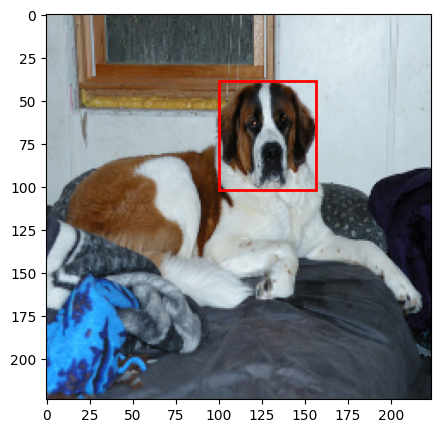

In [8]:
# Function to visualize bounding boxes in the image

def plot_img_bbox(img, target):
    # plot the image and bboxes
    # Bounding boxes are defined as follows: x-min y-min width height
    fig, a = plt.subplots(1,1)
    fig.set_size_inches(5,5)
    a.imshow(img)
    for box in (target['boxes']):
        x, y, width, height  = box[0], box[1], box[2]-box[0], box[3]-box[1]
        rect = patches.Rectangle((x, y),
                                 width, height,
                                 linewidth = 2,
                                 edgecolor = 'r',
                                 facecolor = 'none')

        # Draw the bounding box on top of the image
        a.add_patch(rect)
    plt.show()

# plotting the image with bboxes. Feel free to change the index
img, target = dataset[2]
plot_img_bbox(img, target)

In [9]:

def get_object_detection_model(num_classes):

    # load a model pre-trained pre-trained on COCO
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    return model

In [10]:
# Send train=True fro training transforms and False for val/test transforms
def get_transform(train):

    if train:
        return A.Compose([
                            A.HorizontalFlip(),
                     # ToTensorV2 converts image to pytorch tensor without div by 255
                            ToTensorV2()
                        ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})
    else:
        return A.Compose([
                            ToTensorV2()
                        ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

In [11]:
# use our dataset and defined transformations
dataset = FruitImagesDataset(path, 480, 480, transforms= get_transform(train=True))
dataset_test = FruitImagesDataset(path, 480, 480, transforms= get_transform(train=False))

# split the dataset in train and test set
torch.manual_seed(1)
indices = torch.randperm(len(dataset)).tolist()

# train test split
test_split = 0.2
tsize = int(len(dataset)*test_split)
dataset = torch.utils.data.Subset(dataset, indices[:-tsize])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-tsize:])

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=4, shuffle=True, num_workers=4,
    collate_fn=utils.collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=4, shuffle=False, num_workers=4,
    collate_fn=utils.collate_fn)

len(data_loader), len(data_loader_test)

(738, 185)

In [12]:
# to train on gpu if selected.
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')


num_classes = 3

# get the model using our helper function
model = get_object_detection_model(num_classes)

# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)

# and a learning rate scheduler which decreases the learning rate by
# 10x every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:00<00:00, 203MB/s]


In [13]:
import math
import sys
import time

import torch
import torchvision.models.detection.mask_rcnn
import utils
from coco_eval import CocoEvaluator
from coco_utils import get_coco_api_from_dataset


def train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq, scaler=None):
    model.train()
    metric_logger = utils.MetricLogger(delimiter="  ")
    metric_logger.add_meter("lr", utils.SmoothedValue(window_size=1, fmt="{value:.6f}"))
    header = f"Epoch: [{epoch}]"

    lr_scheduler = None
    if epoch == 0:
        warmup_factor = 1.0 / 1000
        warmup_iters = min(1000, len(data_loader) - 1)

#         lr_scheduler = torch.optim.lr_scheduler.linear_lr(
#             optimizer, start_factor=warmup_factor, total_iters=warmup_iters
#         )
        lr_scheduler = torch.optim.lr_scheduler.StepLR(
            optimizer, step_size=10
        )

    for images, targets in metric_logger.log_every(data_loader, print_freq, header):
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        with torch.cuda.amp.autocast(enabled=scaler is not None):
            loss_dict = model(images, targets)
            losses = sum(loss for loss in loss_dict.values())

        # reduce losses over all GPUs for logging purposes
        loss_dict_reduced = utils.reduce_dict(loss_dict)
        losses_reduced = sum(loss for loss in loss_dict_reduced.values())

        loss_value = losses_reduced.item()

        if not math.isfinite(loss_value):
            print(f"Loss is {loss_value}, stopping training")
            print(loss_dict_reduced)
            sys.exit(1)

        optimizer.zero_grad()
        if scaler is not None:
            scaler.scale(losses).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            losses.backward()
            optimizer.step()

        if lr_scheduler is not None:
            lr_scheduler.step()

        metric_logger.update(loss=losses_reduced, **loss_dict_reduced)
        metric_logger.update(lr=optimizer.param_groups[0]["lr"])

    return

In [14]:
# training for 10 epochs
num_epochs = 1

for epoch in range(num_epochs):
    # training for one epoch
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    evaluate(model, data_loader_test, device=device)

Epoch: [0]  [  0/738]  eta: 1:45:28  lr: 0.005000  loss: 1.7080 (1.7080)  loss_classifier: 1.5557 (1.5557)  loss_box_reg: 0.0966 (0.0966)  loss_objectness: 0.0446 (0.0446)  loss_rpn_box_reg: 0.0111 (0.0111)  time: 8.5748  data: 0.6152  max mem: 3016
Epoch: [0]  [ 10/738]  eta: 0:17:18  lr: 0.000500  loss: 0.3492 (0.4900)  loss_classifier: 0.1857 (0.3269)  loss_box_reg: 0.1435 (0.1411)  loss_objectness: 0.0086 (0.0173)  loss_rpn_box_reg: 0.0043 (0.0048)  time: 1.4262  data: 0.0721  max mem: 3177
Epoch: [0]  [ 20/738]  eta: 0:12:58  lr: 0.000050  loss: 0.2967 (0.3846)  loss_classifier: 0.1409 (0.2258)  loss_box_reg: 0.1399 (0.1386)  loss_objectness: 0.0093 (0.0158)  loss_rpn_box_reg: 0.0036 (0.0043)  time: 0.7097  data: 0.0169  max mem: 3178
Epoch: [0]  [ 30/738]  eta: 0:11:23  lr: 0.000005  loss: 0.2724 (0.3463)  loss_classifier: 0.1113 (0.1873)  loss_box_reg: 0.1397 (0.1395)  loss_objectness: 0.0129 (0.0153)  loss_rpn_box_reg: 0.0035 (0.0043)  time: 0.7123  data: 0.0167  max mem: 3178


AssertionError: ignored

In [15]:
# the function takes the original prediction and the iou threshold.

def apply_nms(orig_prediction, iou_thresh=0.3):

    # torchvision returns the indices of the bboxes to keep
    keep = torchvision.ops.nms(orig_prediction['boxes'], orig_prediction['scores'], iou_thresh)

    final_prediction = orig_prediction
    final_prediction['boxes'] = final_prediction['boxes'][keep]
    final_prediction['scores'] = final_prediction['scores'][keep]
    final_prediction['labels'] = final_prediction['labels'][keep]

    return final_prediction

# function to convert a torchtensor back to PIL image
def torch_to_pil(img):
    return torchtrans.ToPILImage()(img).convert('RGB')

In [31]:
# pick one image from the test set
img, target = dataset_test[5]
# put the model in evaluation mode
model.eval()
with torch.no_grad():
    prediction = model([img.to(device)])[0]

print('predicted #boxes: ', len(prediction['labels']))
print('real #boxes: ', len(target['labels']))

predicted #boxes:  10
real #boxes:  1


EXPECTED OUTPUT


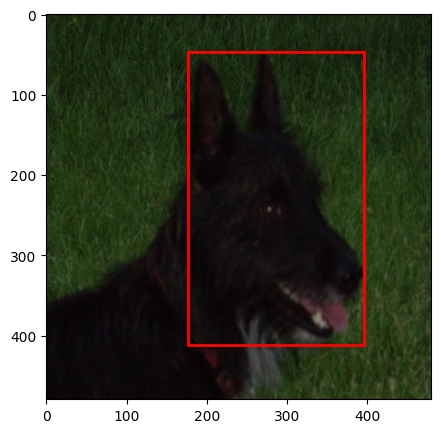

In [32]:
print('EXPECTED OUTPUT')
plot_img_bbox(torch_to_pil(img), target)

In [33]:
def pred_to_cpu(prediction):
  prediction = {
      'boxes': prediction['boxes'].cpu(),
      'labels': prediction['labels'].cpu(),
      'scores': prediction['scores'].cpu()
  }
  return prediction

MODEL OUTPUT


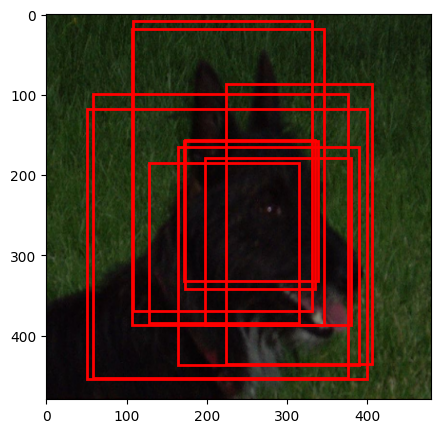

In [34]:
print('MODEL OUTPUT')
plot_img_bbox(torch_to_pil(img), pred_to_cpu(prediction))

NMS APPLIED MODEL OUTPUT


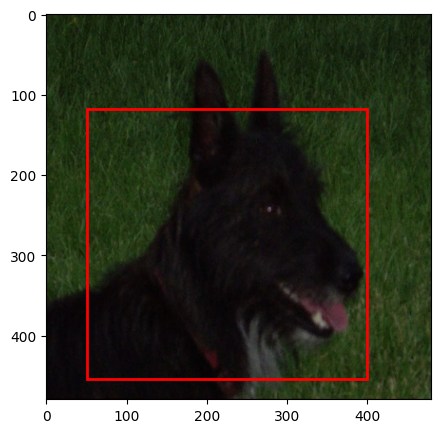

In [36]:
nms_prediction = apply_nms(pred_to_cpu(prediction), iou_thresh=0.2)
print('NMS APPLIED MODEL OUTPUT')
plot_img_bbox(torch_to_pil(img), nms_prediction)

torch.Size([3, 480, 480])
EXPECTED OUTPUT



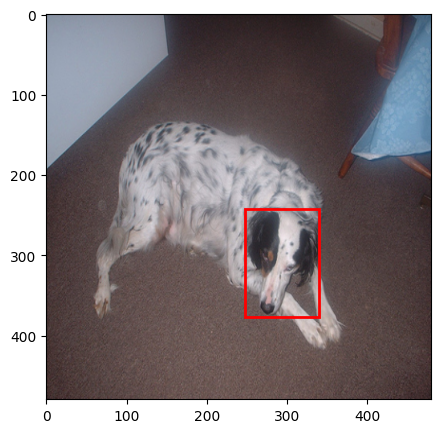

MODEL OUTPUT



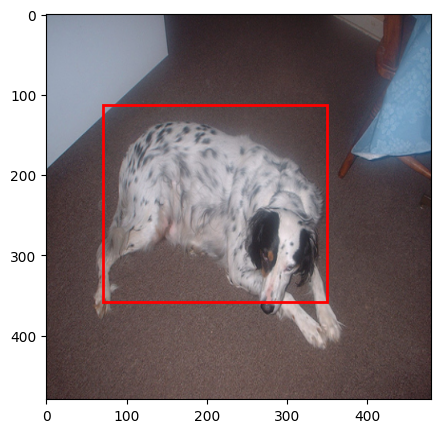

In [37]:
test_dataset = FruitImagesDataset(path, 480, 480, transforms= get_transform(train=True))
# pick one image from the test set
img, target = test_dataset[10]
print(img.shape)
# put the model in evaluation mode
model.eval()
with torch.no_grad():
    prediction = model([img.to(device)])[0]

print('EXPECTED OUTPUT\n')
plot_img_bbox(torch_to_pil(img), target)
print('MODEL OUTPUT\n')
nms_prediction = apply_nms(pred_to_cpu(prediction), iou_thresh=0.01)

plot_img_bbox(torch_to_pil(img), nms_prediction)

# deployment

In [38]:
torch.save(model.state_dict(),'model')
model.load_state_dict(torch.load('model'))
# model.eval()

<All keys matched successfully>

In [40]:
from glob import glob
images = get_image_files(path/'images')
images[:5]

(#5) [Path('images/pug_109.jpg'),Path('images/Ragdoll_82.jpg'),Path('images/havanese_137.jpg'),Path('images/english_cocker_spaniel_128.jpg'),Path('images/wheaten_terrier_128.jpg')]

In [41]:
img = Image.open(images[2])
img = img.resize((480, 480))
tfms = torchtrans.ToTensor()
img = tfms(img)
img.dtype, img.shape

(torch.float32, torch.Size([3, 480, 480]))

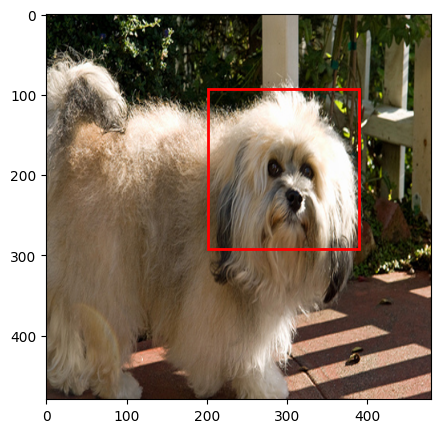

In [46]:
# put the model in evaluation mode
model.eval()
with torch.no_grad():
    prediction = model([img.to(device)])[0]
nms_prediction = apply_nms(pred_to_cpu(prediction), iou_thresh=0.01)
plot_img_bbox(torch_to_pil(img), nms_prediction)